In [1]:
import os
from typing import Literal, Any, Optional, Union
import sys

import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes
import matplotlib.figure
import matplotlib.text
import matplotlib.backend_bases
import matplotlib.offsetbox
import matplotlib.collections
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from umap import UMAP
import requests
from tqdm.notebook import tqdm


In [2]:
print(sys.version)


3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]


In [3]:
print(f"matplotlib version: {matplotlib.__version__}")


matplotlib version: 3.8.0


In [4]:
# need ipympl installed
# interactive plots
%matplotlib widget


In [5]:
# ダウンロードするファイルのURL
url = "http://datachemeng.wp.xdomain.jp/wp-content/uploads/2017/04/logSdataset1290_2d.sdf"

# ダウンロード先のディレクトリ
download_dir = "data"

# ローカルに保存するファイルのパス
local_file_path = os.path.join(download_dir, "logSdataset1290_2d.sdf")

# ファイルが既に存在するかチェック
if not os.path.exists(local_file_path):
    # ファイルをダウンロード
    response = requests.get(url)
    if response.status_code == 200:
        # ダウンロード成功時にローカルに保存
        os.makedirs(download_dir, exist_ok=True)
        with open(local_file_path, "wb") as file:
            file.write(response.content)
        print("ファイルをダウンロードしました。")
    else:
        print("ファイルのダウンロードに失敗しました。")
else:
    print("ファイルは既にローカルに存在します。ダウンロードをスキップします。")


ファイルは既にローカルに存在します。ダウンロードをスキップします。


In [6]:
# SDFファイルのパス
sdf_file_path = "data/logSdataset1290_2d.sdf"

# SDFファイルをDataFrameに読み込む
df = PandasTools.LoadSDF(sdf_file_path)

# DataFrameを表示
df.head()


,CAS_Number,logS,ID,ROMol,CA_Number
0,60-35-5,1.58,CC(N)=O,<rdkit.Chem.rdchem.Mol object at 0x154efcd60>,NaN
1,NaN,1.34,CNN,<rdkit.Chem.rdchem.Mol object at 0x154efc430>,60-34-4
2,NaN,1.22,CC(O)=O,<rdkit.Chem.rdchem.Mol object at 0x154efc7b0>,64-19-7
3,NaN,1.15,C1CCCN1,<rdkit.Chem.rdchem.Mol object at 0x154efd230>,123-75-1
4,NaN,1.12,NC([NH]O)=O,<rdkit.Chem.rdchem.Mol object at 0x154efd2a0>,127-07-1


In [7]:
mols = df["ROMol"].tolist()
smiles = list(map(Chem.MolToSmiles, mols))


In [8]:
# create all features in rdkit.Chem.Descriptors
from rdkit.Chem import Descriptors

X = pd.DataFrame.from_dict(
    {
        desc_name: map(desc_func, mols)
        for desc_name, desc_func in tqdm(Descriptors.descList)
    }
)
X.head()


  0%|          | 0/211 [00:00<?, ?it/s]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.222222,9.222222,0.333333,-0.333333,0.401031,6.25,59.068,54.028,59.037114,24,...,0,0,0,0,0,0,0,0,0,0
1,4.597222,4.597222,1.652778,1.652778,0.273315,6.00,46.073,40.025,46.053098,20,...,0,0,0,0,0,0,0,0,0,0
2,9.000000,9.000000,0.833333,-0.833333,0.429883,6.25,60.052,56.020,60.021129,24,...,0,0,0,0,0,0,0,0,0,0
3,3.222222,3.222222,1.250000,1.250000,0.434794,24.00,71.123,62.051,71.073499,30,...,0,0,0,0,0,0,0,0,0,0
4,9.229167,9.229167,0.939815,-0.939815,0.256644,6.60,76.055,72.023,76.027277,30,...,0,0,0,0,0,0,0,0,0,1


In [9]:
umap = UMAP(
    n_neighbors=15,
    n_components=2,
    # metric="mahalanobis",
    metric="euclidean",
    # random_state=42,
    # metric_kwds=dict(VI=np.cov(X, rowvar=False)),
    n_jobs=-1,
)
X_umap = umap.fit_transform(X)


\# TODO

- 物性値の表示
- 画像サイズの変更 (スクロール)
- <s>zorderの調整 (とにかく最大のzorderに+1するで実現できる？)</s>
- <s>クラス化して、グローバル変数を排除する</s>
- <s>htmlに書き出す</s>

In [10]:
class _DragAndDrop:
    def __init__(
        self,
        annotations: list[matplotlib.offsetbox.AnnotationBbox] = [],
        zorder_max: int = 3,
        ax: Optional[matplotlib.axes.Axes] = None,
    ) -> None:
        self.annotations = annotations
        self.zorder_max = zorder_max
        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax

        self._dragging_annotation: Optional[
            matplotlib.offsetbox.AnnotationBbox
        ] = None

    def on_press(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        if event.inaxes == self.ax:
            for _annotation in self.annotations:
                contains, _ = _annotation.contains(event)
                if contains:
                    self._dragging_annotation = _annotation

                    # 一番手前に持ってくる
                    if _annotation.zorder < self.zorder_max:
                        self.zorder_max += 1
                        _annotation.set(zorder=self.zorder_max)

                    # ダブルクリックしたら削除
                    if event.dblclick:
                        self.annotations.remove(_annotation)
                        _annotation.remove()

    def on_release(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        self._dragging_annotation = None

    def on_motion(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        if (
            type(self._dragging_annotation)
            is matplotlib.offsetbox.AnnotationBbox
        ):
            self._dragging_annotation.xybox = (
                event.xdata,
                event.ydata,
            )
            # 再描画
            self.ax.figure.canvas.draw_idle()


class InteractiveChemicalViewer:
    def __init__(
        self,
        ax: Optional[matplotlib.axes.Axes] = None,
        width: Union[int, float] = 25,
        scale: float = 0.2,
    ) -> None:
        # CONSTANTS
        self.zorder_max: int = 3

        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax
        self.fig = self.ax.figure

        self.width = width
        self.scale = scale

        # 画像の場合
        # imagebox
        self.imagebox_hover = matplotlib.offsetbox.OffsetImage(
            np.zeros((2, 2)), zoom=self.scale
        )  # 適当な画像
        self.imagebox_hover.image.axes = self.ax

        self.annotation_hover = matplotlib.offsetbox.AnnotationBbox(
            self.imagebox_hover,
            xy=(0, 0),
            xybox=(self.width, self.width),
            xycoords="data",
            # boxcoords="offset points",
            boxcoords="data",
            pad=0.5,
            arrowprops=dict(arrowstyle="->"),
        )
        self.annotation_hover.set_visible(False)
        self.ax.add_artist(self.annotation_hover)

        self.annotations: list[matplotlib.offsetbox.AnnotationBbox] = []
        self._drag_and_drop = _DragAndDrop(
            annotations=self.annotations,
            zorder_max=self.zorder_max,
            ax=self.ax,
        )

        self.fig.canvas.mpl_connect("motion_notify_event", self.hover)
        self.fig.canvas.mpl_connect("button_press_event", self.onclick)

        self.fig.canvas.mpl_connect("button_press_event", self.on_press)
        self.fig.canvas.mpl_connect("button_release_event", self.on_release)
        self.fig.canvas.mpl_connect("motion_notify_event", self.on_motion)

        self.fig.canvas.mpl_connect(
            'key_press_event', self.resize_annotation
        )

        self.fig.tight_layout()

    def scatter(
        self, mols: list[Chem.rdchem.Mol], x: ArrayLike, y: ArrayLike, **kwargs
    ) -> None:
        assert (
            len(mols) == len(x) == len(y)
        ), "lengths of mols, x, and y must be the same"
        self.scatter_object = self.ax.scatter(x, y, **kwargs)

    def _update_annotation(
        self,
        details: dict[Literal["ind"], np.ndarray[Any, np.dtype[np.int32]]],
    ) -> None:
        # details["ind"]でマウスが乗っているscatterのindexが取得できる
        # scatterのindexが1次元のnp.ndarrayで返ってくる。（複数が重なっていることもあるため）
        index: int = details["ind"][0]

        # 当該点の座標を取得して、位置を更新
        position = self.scatter_object.get_offsets()[index]
        self.annotation_hover.xy = position

        # テキストを更新
        # text = "testtesttest"
        # annotation.set_text(text)
        # annot.get_bbox_patch().set_facecolor(cmap(int(text)/10))

        # 画像を更新
        self.imagebox_hover.set_data(Draw.MolToImage(mols[index]))

    def onclick(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        """クリックしたら画像を表示したままにする"""
        # マウスが乗っているのが当該axならば
        # かつ、annotationのどれにもマウスが乗っていないならば
        if event.inaxes == self.ax and not any(
            _annotation.contains(event)[0] for _annotation in self.annotations
        ):
            # scatter_objectのcontainsメソッドで、マウスが乗っているかどうかを判定
            contains, details = self.scatter_object.contains(event)
            # マウスが乗っている場合
            if contains:
                index: int = details["ind"][0]

                _imagebox = matplotlib.offsetbox.OffsetImage(
                    Draw.MolToImage(mols[index]), zoom=self.scale
                )
                _imagebox.image.axes = self.ax

                self.zorder_max += 1
                _annotation = matplotlib.offsetbox.AnnotationBbox(
                    _imagebox,
                    xy=self.scatter_object.get_offsets()[index],
                    xybox=(self.width, self.width),
                    xycoords="data",
                    boxcoords="data",
                    # boxcoords="offset points",
                    pad=0.5,
                    arrowprops=dict(arrowstyle="->", facecolor="black"),
                    zorder=self.zorder_max,
                )

                _annotation.set_visible(True)
                self.ax.add_artist(_annotation)

                # 移動可能にするために保存
                self.annotations.append(_annotation)

                self._drag_and_drop = _DragAndDrop(
                    annotations=self.annotations,
                    zorder_max=self.zorder_max,
                    ax=self.ax,
                )

    def hover(
        self,
        event: matplotlib.backend_bases.MouseEvent,
    ) -> None:
        visibility = self.annotation_hover.get_visible()
        # マウスが乗っているのが当該axならば
        # かつ、annotationのどれにもマウスが乗っていないならば
        if event.inaxes == self.ax and not any(
            _annotation.contains(event)[0] for _annotation in self.annotations
        ):
            # scatter_objectのcontainsメソッドで、マウスが乗っているかどうかを判定
            contains, details = self.scatter_object.contains(event)
            # マウスが乗っている場合
            if contains:
                # annotationを更新して
                self._update_annotation(details)
                # 見えるようにして
                self.annotation_hover.set_visible(True)
                # 一番手前にして
                if self.annotation_hover.zorder < self.zorder_max:
                    self.zorder_max += 1
                    self.annotation_hover.set(zorder=self.zorder_max)
                # 再描画
                self.fig.canvas.draw_idle()
            # マウスが乗っていない場合
            else:
                # 今annotationが見えているならば
                if visibility:
                    # annotationを見えなくする
                    self.annotation_hover.set_visible(False)
                    # 再描画
                    self.fig.canvas.draw_idle()

    def on_press(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        self._drag_and_drop.on_press(event)

    def on_release(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        self._drag_and_drop.on_release(event)

    def on_motion(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        self._drag_and_drop.on_motion(event)

    def resize_annotation(
        self, event: matplotlib.backend_bases.KeyEvent
    ) -> None:
        if event.inaxes == self.ax:
            for _annotation in self.annotations:
                contains, _ = _annotation.contains(event)
                if contains:
                    # 上キー/下キーでoffsetboxを拡大縮小できる
                    offset_image: matplotlib.offsetbox.OffsetImage = (
                        _annotation.offsetbox
                    )
                    if event.key == "up":
                        offset_image.set_zoom(offset_image.get_zoom() * 1.1)
                    elif event.key == "down":
                        offset_image.set_zoom(offset_image.get_zoom() * 0.9)
                    # 再描画
                    self.fig.canvas.draw_idle()
                    break
            else:
                for _annotation in self.annotations:
                    offset_image: matplotlib.offsetbox.OffsetImage = (
                        _annotation.offsetbox
                    )
                    if event.key == "up":
                        offset_image.set_zoom(offset_image.get_zoom() * 1.1)
                    elif event.key == "down":
                        offset_image.set_zoom(offset_image.get_zoom() * 0.9)
                    # 再描画
                    self.fig.canvas.draw_idle()


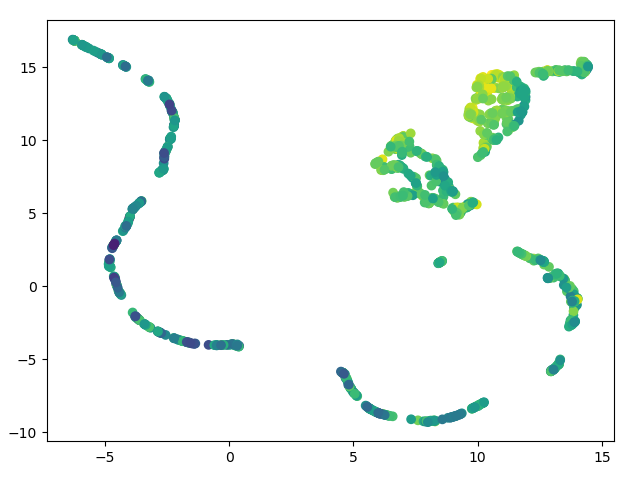

False
False
True
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
False
True
False
True
False
True
False
True
False
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fa

In [11]:
viewer = InteractiveChemicalViewer(width=1)
viewer.scatter(mols, X_umap[:, 0], X_umap[:, 1], c=df["logS"].astype(float))


In [ ]:
WIDTH = 25
SCALE = 0.2

# zorder_max = 10

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    facecolor="white",
    figsize=(4.8, 4.8),  # dpi=300
)
ax: matplotlib.axes.Axes  # 本来は不要だが、明示
# 適当にプロット
scatter_object = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.5)

# テキストの場合
# 空のannotationを作成
# annotation = ax.annotate(
#     "",
#     xy=(0, 0),
#     xytext=(20, 20),
#     textcoords="offset points",
#     bbox=dict(boxstyle="round", fc="w"),
#     arrowprops=dict(arrowstyle="->"),
# )
# annotation.set_visible(False)

# 画像の場合
# imagebox
imagebox_hover = matplotlib.offsetbox.OffsetImage(
    # Draw.MolToImage(mols[0]), zoom=SCALE
    np.zeros((2, 2)),
    zoom=SCALE,
)
imagebox_hover.image.axes = ax

annotations: list[matplotlib.offsetbox.AnnotationBbox] = []

annotation_hover = matplotlib.offsetbox.AnnotationBbox(
    imagebox_hover,
    xy=(0, 0),
    xybox=(WIDTH, WIDTH),
    xycoords="data",
    boxcoords="offset points",
    pad=0.5,
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.3"),
)
annotation_hover.set_visible(False)
ax.add_artist(annotation_hover)


def update_annotation(
    details: dict[Literal["ind"], np.ndarray[Any, np.dtype[np.int32]]]
) -> None:
    # details["ind"]でマウスが乗っているscatterのindexが取得できる
    # scatterのindexが1次元のnp.ndarrayで返ってくる。（複数が重なっていることもあるため）
    index: int = details["ind"][0]

    # 当該点の座標を取得して、位置を更新
    position = scatter_object.get_offsets()[index]
    annotation_hover.xy = position

    # テキストを更新
    # text = "testtesttest"
    # annotation.set_text(text)
    # annot.get_bbox_patch().set_facecolor(cmap(int(text)/10))

    # 画像を更新
    imagebox_hover.set_data(Draw.MolToImage(mols[index]))


def onclick(event: matplotlib.backend_bases.MouseEvent) -> None:
    # クリックしたら画像を表示したままにする
    # マウスが乗っているのが当該axならば
    if event.inaxes == ax:
        # scatter_objectのcontainsメソッドで、マウスが乗っているかどうかを判定
        contains, details = scatter_object.contains(event)
        # マウスが乗っている場合
        if contains:
            index: int = details["ind"][0]

            _imagebox = matplotlib.offsetbox.OffsetImage(
                Draw.MolToImage(mols[index]), zoom=SCALE
            )
            _imagebox.image.axes = ax

            # zorder_max = zorder_max + 1
            _annotation = matplotlib.offsetbox.AnnotationBbox(
                _imagebox,
                xy=scatter_object.get_offsets()[index],
                xybox=(WIDTH, WIDTH),
                xycoords="data",
                boxcoords="offset points",
                pad=0.5,
                arrowprops=dict(arrowstyle="->", facecolor="black"),
                # zorder=zorder_max,
            )

            delete_button = matplotlib.offsetbox.DrawingArea(
                width=30, height=30
            )
            delete_button.add_artist(plt.Circle((15, 15), 12, color="red"))

            _annotation.set_visible(True)
            ax.add_artist(_annotation)

            # 移動可能にするために保存
            annotations.append(_annotation)


def hover(
    event: matplotlib.backend_bases.MouseEvent,
) -> None:
    visibility = annotation_hover.get_visible()
    # マウスが乗っているのが当該axならば
    if event.inaxes == ax:
        # scatter_objectのcontainsメソッドで、マウスが乗っているかどうかを判定
        contains, details = scatter_object.contains(event)
        # マウスが乗っている場合
        if contains:
            # annotationを更新して
            update_annotation(details)
            # 見えるようにして
            annotation_hover.set_visible(True)
            # 一番手前にして
            # if annotation_hover.zorder < zorder_max:
            #     zorder_max = zorder_max + 1
            #     annotation_hover.zorder = zorder_max
            # 再描画
            fig.canvas.draw_idle()
        # マウスが乗っていない場合
        else:
            # 今annotationが見えているならば
            if visibility:
                # annotationを見えなくする
                annotation_hover.set_visible(False)
                # 再描画
                fig.canvas.draw_idle()


class DragAndDrop:
    def __init__(self) -> None:
        self._dragging_annotation: Optional[
            matplotlib.offsetbox.AnnotationBbox
        ] = None

    def on_press(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        if event.inaxes == ax:
            for _annotation in annotations:
                contains, _ = _annotation.contains(event)
                if contains:
                    self._dragging_annotation = _annotation
                    # 一番手前に持ってくる
                    # if annotation_hover.zorder < zorder_max:
                    #     zorder_max = zorder_max + 1
                    #     _annotation.zorder = zorder_max
                    # ダブルクリックしたら削除
                    if event.dblclick:
                        annotations.remove(_annotation)
                        _annotation.remove()

    def on_release(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        self._dragging_annotation = None

    def on_motion(self, event: matplotlib.backend_bases.MouseEvent) -> None:
        if (
            type(self._dragging_annotation)
            is matplotlib.offsetbox.AnnotationBbox
        ):
            self._dragging_annotation.xy = (event.xdata, event.ydata)
            # 再描画
            fig.canvas.draw_idle()


drag_and_drop = DragAndDrop()

# "motion_notify_event"
fig.canvas.mpl_connect("motion_notify_event", hover)
fig.canvas.mpl_connect("button_press_event", onclick)

fig.canvas.mpl_connect("button_press_event", drag_and_drop.on_press)
fig.canvas.mpl_connect("button_release_event", drag_and_drop.on_release)
fig.canvas.mpl_connect("motion_notify_event", drag_and_drop.on_motion)

fig.tight_layout()


mpld3ではhtmlをエスケープすることなく表示できる。

したがって、svgおよびtextを適当に表示できる。

matplotlibのインタラクティブな機能をそのまま使用することはできなかった。
